# GP Regression on Noisy Sinusoidal Data

Original tutorial: [Gaussian Process Regression in TensorFlow Probability](https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP)

Translated to `pymc3` using: 
- Tutorial [Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html)
- Example [Marginal Likelihood Implementation](https://docs.pymc.io/notebooks/GP-Marginal.html)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

In [2]:
import warnings
        
# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# set the seed
np.random.seed(1)

## Create Sinusoidal data with Gaussian noise

In [4]:
def sinusoid(x):
    return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
    """
      Generate noisy sinusoidal observations at a random set of points.

      Returns:
         observation_index_points, observations
    """
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
    # y = f(x) + noise
    observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
    return index_points_, observations_

In [5]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [6]:
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

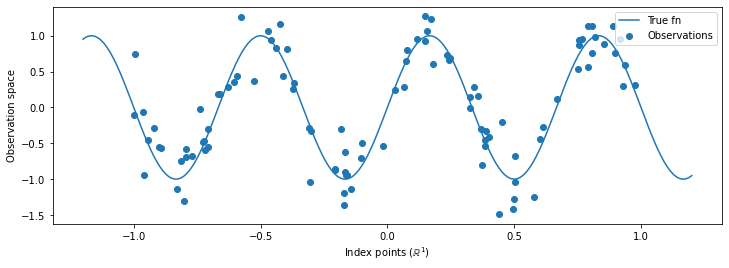

In [7]:
# Plot the true function and observations.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Coding the model in PyMC3
A common application of Gaussian processes in machine learning is Gaussian process regression. The idea is that we wish to estimate an unknown function given noisy observations $y_1, ..., y_N$ of the function at a finite number of points $x_1, ..., x_N$. We imagine a generative process
$$ f(x) \sim GP(m(x), k(x,x'))$$
$$ y_i \sim Normal(\mu = f(x_i), \sigma=\sigma)$$


Below we make use of the ExponentiatedQuadratic covariance kernel. Its form is
$$ k(x,x'):= \sigma^2 \exp \left( \frac{{\lVert}x-x'{\rVert}^2}{\lambda^2} \right)$$


In [8]:
with pm.Model() as model:
    ℓ = pm.Lognormal("ℓ", mu=0., sigma=1.0) # 0.1
    η = pm.Lognormal("η", mu=0., sigma=1.0) # 1.0
    # Specify the covariance function.
    cov = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.Lognormal("σ", mu=0., sigma=1.)
    y_ = gp.marginal_likelihood("y", X=observation_index_points_, y=observations_, noise=σ)
    
    mp = pm.find_MAP()

In [11]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
import pandas as pd
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
              "True value": [0.1, 1.0, 0.1]})

,Parameter,Value at MAP,True value
0,ℓ,0.178389,0.1
1,η,0.850670,1.0
2,σ,0.297092,0.1


### Use `.conditional`

In [12]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", predictive_index_points_)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

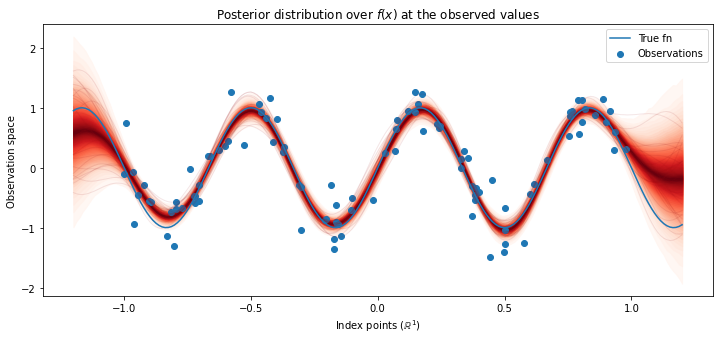

In [23]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist


plot_gp_dist(ax, pred_samples["f_pred"], predictive_index_points_)

# plot the data and the true latent function
ax.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
ax.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.title("Posterior distribution over $f(x)$ at the observed values");
plt.show()

### Draw posterior predictive distribution

In [15]:
with model:
    y_pred = gp.conditional("y_pred", predictive_index_points_, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=2000)

In [21]:
X = np.linspace(-1.0, 1.0, 200, dtype=np.float64)[..., np.newaxis]

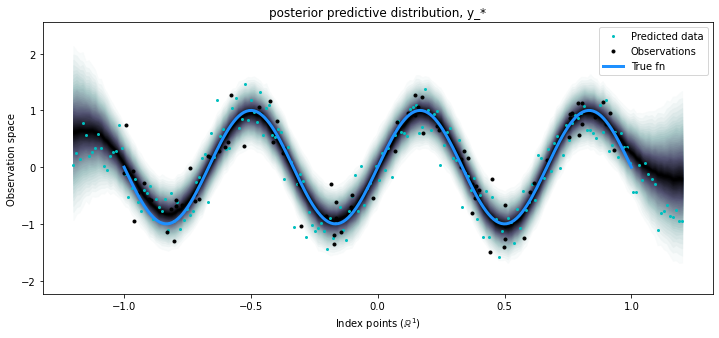

In [22]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], predictive_index_points_, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(predictive_index_points_, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(observation_index_points_[:, 0], observations_, 'ok', ms=3, alpha=1.0, label="Observations");
plt.plot(X, sinusoid(X), "dodgerblue", lw=3, label="True fn");

plt.title("posterior predictive distribution, y_*"); plt.legend();
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

### Tensorflow probability vs. PyMC3
The Exponentiated Quadratic kernel. Also refered to as the Squared Exponential, or Radial Basis Function kernel.

`tfp`
$$ k(x,x'):= \sigma^2 \exp \left( \frac{{\lVert}x-x'{\rVert}^2}{\lambda^2} \right)$$
```python
tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude=None, length_scale=None, feature_ndims=1, validate_args=False,
    name='ExponentiatedQuadratic'
)
```
while `pymc3` 
$$ k(x,x'):= \exp \left( \frac{{\lVert}x-x'{\rVert}^2}{\lambda^2} \right)$$
```python
pymc3.gp.cov.ExpQuad(input_dim, ls=None, ls_inv=None, active_dims=None)
```


